In [107]:
import os
import sys
import glob
import re
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import matplotlib.image as mpimg
mpl.style.use('classic')

import pydicom as dcm
import pylab

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

# General settings

In [319]:
# See https://stackoverflow.com/questions/14722540/smoothing-between-pixels-of-imagesc-imshow-in-matlab-like-the-matplotlib-imshow
mpl.rcParams['image.interpolation'] = 'none' # default 'bilinear'

layout=Layout(width='90%') # For ipywidgets

In [210]:
home = str(Path.home())
data_dir = f"{home}/data/aneurysm/"
PATH = Path(data_dir)
# STL
stl_dir = f"{home}/data/aneurysm/stls.ours/"

# Dicom
dcm_dir = f"{home}/data/aneurysm/512Auto.ours/"
mask_dir = f"{home}/data/aneurysm/512Auto.ours.masks/"

# PNG
pngs_dir = f"{home}/data/aneurysm/train-512/"
masks_pngs_dir = f"{home}/data/aneurysm/train_masks-512/"

dirs = [data_dir,mask_dir,stl_dir,dcm_dir,pngs_dir,masks_pngs_dir]

In [211]:
# for d in dirs:
#      !mkdir -p {d}
!tree --filelimit=12 {data_dir}
!pwd

/home/amer/data/aneurysm/
├── 512Auto.masks.pngs.tar.gz
├── 512Auto.ours [13 entries exceeds filelimit, not opening dir]
├── 512Auto.ours.masks [13 entries exceeds filelimit, not opening dir]
├── 512Auto.pngs.tar.gz
├── stls.ours
│   ├── A012.stl
│   ├── A013.stl
│   ├── A015.stl
│   └── A016.stl
├── train-128
├── train-512 [30418 entries exceeds filelimit, not opening dir]
├── train_masks-128
└── train_masks-512 [30418 entries exceeds filelimit, not opening dir]

7 directories, 6 files
/home/amer/Code/ML_for_Medical_Image_Processing


In [212]:
!ls -1 {pngs_dir} | wc -l 

30418


# Data exploration

In [205]:
reg_complete_filename = re.compile("[^/]*$") # Match a file name in a path
reg_filename = re.compile("^([^.]+)") # Match a file name in a path

def get_filename(paths,num):
    complete_filename = re.search(reg_complete_filename, paths[num]).group(0)
    return re.search(reg_filename, complete_filename).group(0)
    
def get_dicoms_paths(source_dir):
    return sorted(glob.glob(f"{source_dir}*.dcm"))

In [206]:
def get_pngs(dicoms_paths,dcm_num):
    ds = dcm.read_file(dicoms_paths[dcm_num]) # get the dicom file #dcm_num
    return ds.pixel_array

# Shows one image
def browse_dicom(source_dir,dicom_num):
    dicoms_paths = get_dicoms_paths(source_dir)
    pngs = get_pngs(dicoms_paths,dicom_num)
    last = len(pngs)-1
    print(dicoms_paths[dicom_num])
    def show_png(num):
        pylab.imshow(pngs[num],cmap=pylab.cm.bone)
    interact(show_png, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout));

# Shows original and mask side by side
def browse_dicom_and_mask(original_dir,mask_dir,dicom_num):
    original_paths = get_dicoms_paths(original_dir)
    mask_paths = get_dicoms_paths(mask_dir)
    
    original_pngs = get_pngs(original_paths,dicom_num)
    mask_pngs = get_pngs(mask_paths,dicom_num)
    
    last = len(original_pngs)-1
    print(original_paths[dicom_num])
    print(mask_paths[dicom_num])
    def show_png(num):
        f = plt.figure(figsize=(20,10))
        f.add_subplot(1,2, 1)
        pylab.imshow(original_pngs[num],cmap=pylab.cm.bone)
        f.add_subplot(1,2, 2)
        pylab.imshow(mask_pngs[num],cmap=pylab.cm.bone)
        plt.show(block=True)
    interact(show_png, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout))

In [323]:
browse_dicom_and_mask(dcm_dir,mask_dir,10)

/home/amer/data/aneurysm/512Auto.ours/A025.dcm
/home/amer/data/aneurysm/512Auto.ours.masks/A025.mask.dcm


interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=438), Output()), _…

In [11]:
#browse_dicom(dcm_dir,1) # Show me the MRI Dicom file #2
#browse_dicom(mask_dir,1) # Show me the Mask Dicom file #2

In [12]:
def save_dicom_to_pngs(source_dir,target_dir,dicom_num):
    paths = get_dicoms_paths(source_dir)
    dicom_file_name = get_filename(paths,dicom_num)
    pngs = get_pngs(paths,dicom_num)
    slice_count = len(pngs)-1
    for i in range(dicom_num,slice_count):
        pylab.imsave(f"{target_dir}{dicom_file_name}_{i}",pngs[i],cmap=pylab.cm.bone)
    return slice_count+1

In [13]:
def breakup_dicom(source_dir,target_dir): # Dicom to pngs
    dicom_paths = get_dicoms_paths(source_dir) # Get dicoms files
    file_count = len(dicom_paths) # Count dicom files
    for i in range(0,file_count):
        print(f"Breaking up {get_filename(dicom_paths,i)} into pngs...")
        slice_num = save_dicom_to_pngs(source_dir,target_dir,i)
        print(f"Finished {get_filename(dicom_paths,i)}! {slice_num} slices were saved.\n")
    print(f"PNGs are in {pngs_dir}")

In [14]:
#breakup_dicom(dcm_dir,pngs_dir)

In [15]:
#breakup_dicom(mask_dir,masks_pngs_dir)

In [16]:
d

In [315]:
def show_scaled_dicom(source_dir,dcm_index):
    dicoms_paths = get_dicoms_paths(source_dir)
    dcm = get_pngs(dicoms_paths,dcm_index)
    last = last = len(dcm)-1
    print(last)
    def show_img(num):
        _slice = dcm[num]
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(_slice)
        scaled = scaler.transform(_slice)
        plt.figure(figsize=(8,8))
        pylab.imshow(scaled,cmap=pylab.cm.bone)
    interact(show_img, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout));

In [317]:
show_scaled_dicom(dcm_dir,6)

438


interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=438), Output()), _…

In [20]:
tensor = dicom_as_tensor(3)[0]
# print(np.shape(tensor))
# w = 200 # window1
# m = 1 # stried
print(np.shape(tensor))
#print(tensor[m:m+w,m:m+w])
# plt.figure(figsize=(8,8))
# pylab.imshow(tensor,cmap=pylab.cm.bone)

(512, 512)


In [320]:
tensor = dicom_as_tensor(3)[0]
# Sliding window
def tensor_window(tensor):
    height = np.shape(tensor)[0]
    width = np.shape(tensor)[1]
    def move_window(x,y,w):
        print(np.shape(tensor))
        print(f'[x-w:x,y-w:y]: [{max([x-w,0])}:{x},{max([y-w,0])}:{y}]')
        wx = max([x-w,0])
        wy = max([y-w,0])
        print(f'Window= {w}x{w}')
        t = tensor[wx:x,wy:y]
        pylab.imshow(t,cmap=pylab.cm.bone)
    s = 1 # stried
    interact(move_window,
             x=widgets.IntSlider(min=10,max=height,step=s,layout=layout),
             y=widgets.IntSlider(min=10,max=width,step=s,layout=layout),
             w=widgets.IntSlider(min=20,max=512,step=1,layout=layout),)
    
    
tensor_window(tensor)

interactive(children=(IntSlider(value=10, description='x', layout=Layout(width='90%'), max=512, min=10), IntSl…

124

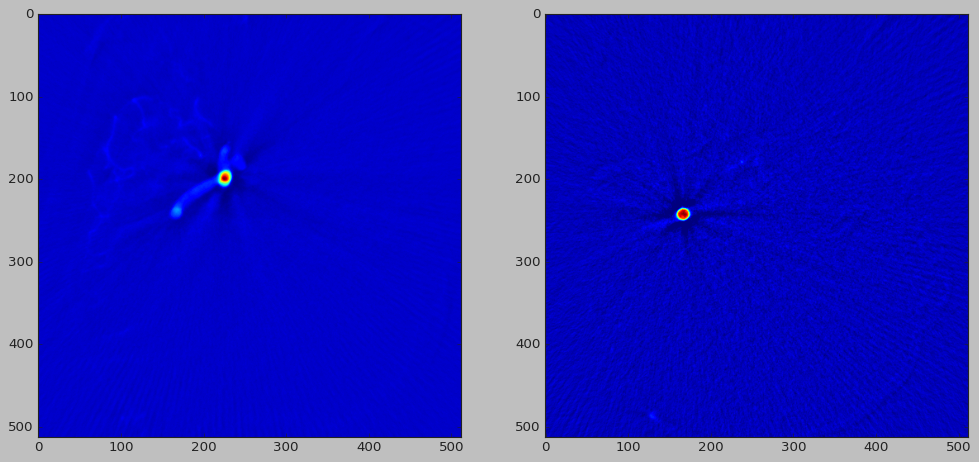

In [103]:
# Slices sum 
slice_index = 120 # First slice
slices_to_sum = 100 # Starting from the slice number slice_index

slice_ = np.sum(dicom_as_tensor(3)[slice_index:slice_index+slices_to_sum],axis=0)

f = plt.figure(figsize=(15,10))
f.add_subplot(1,2, 1)
plt.imshow(slice_)
f.add_subplot(1,2, 2)
plt.imshow(dicom_as_tensor(3)[slice_index])

# The Deep Learning module

In [75]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [78]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(0)

# Read and show PNG functions

/home/amer/data/aneurysm/512Auto.pngs/A031_228.png
/home/amer/data/aneurysm/512Auto.masks.pngs/A031_228.png


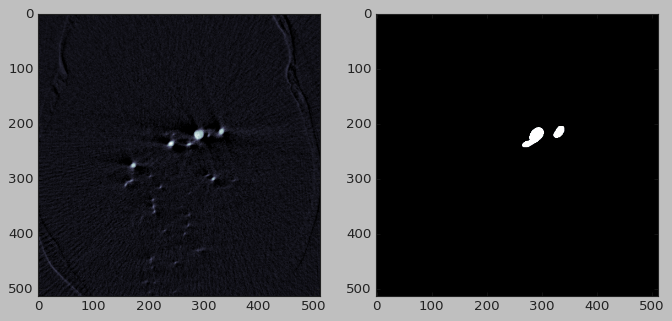

In [156]:
images = list(Path(pngs_dir).iterdir())
masks = list(Path(masks_pngs_dir).iterdir())

img_id = 300

# @kind "I" for Images or "M" for masks
def get_path(index=0,kind="I"):
    if kind == "I":
        return str(images[index])
    else:
        return str(masks[index])

def read_png(index=0,kind="I"):
    if kind == "I":
        return mpimg.imread(get_path(index,kind="I"))
    else:
        return mpimg.imread(get_path(index,kind="M"))

def show_png(index=0,kind="I"):
    if kind == "I":
        plt.imshow(read_png(index,kind="I"))
    else:
        plt.imshow(read_png(index,kind="M"))


index = 5444

print(get_path(index,kind="I"))
print(get_path(index,kind="M"))

f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
show_png(index=index,kind="I")
f.add_subplot(1,2, 2)
show_png(index=index,kind="M")

# Resize PNG

In [170]:
(PATH/'train_masks-128').mkdir(exist_ok=True)
(PATH/'train-128').mkdir(exist_ok=True)

In [181]:
!ls {PATH}

512Auto.masks.pngs	   512Auto.ours.masks	stls.ours
512Auto.masks.pngs.tar.gz  512Auto.pngs		train-128
512Auto.ours		   512Auto.pngs.tar.gz	train_masks-128


In [239]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks-512').iterdir())
with ThreadPoolExecutor(6) as e: e.map(resize_mask, files)

In [240]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train-512').iterdir())
with ThreadPoolExecutor(6) as e: e.map(resize_img, files)

# Remove misleading images with wrong masks

In [365]:
def get_dicom_files_ids_from_pngs():
    return np.unique([re.sub(r"_.*", "", x.parts[-1]) for x in (PATH/'train_masks-512/').rglob("*.png")])

files_ids = get_dicom_files_ids_from_pngs()
files_ids

array(['A012', 'A013', 'A015', 'A016', 'A017', 'A018', 'A019', 'A022', 'A023', 'A024', 'A025', 'A027',
       'A029', 'A031', 'A032', 'A033', 'A036', 'A040', 'A041', 'A042', 'A043', 'A046', 'A047', 'A049',
       'A050', 'A051', 'A054', 'A057', 'A064', 'A065', 'A066', 'A067', 'A071', 'A072', 'A074', 'A075',
       'A077', 'A080', 'A081', 'A082', 'A083', 'A084', 'A086', 'A087', 'A088', 'A089', 'A091', 'A092',
       'A093', 'A095', 'A097', 'A098', 'A100', 'A101', 'A103', 'A107', 'A109', 'A112', 'A115', 'A123',
       'A126', 'A133', 'A134', 'A135', 'A137'], dtype='<U4')

In [324]:
mask_tensor = mask_as_tensor(10)

# Observation: In the most if not all of the dicom files
# labels are missing for the first slices even the artery is clearly there
# This function returns from which slice the leabling started
# For mask #6 = 54
# For mask #10 = 124
# Every mask before this number is misleading
# @tensor (512x512)
def get_first_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last):
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i
        
get_first_nonempty_slice_index(mask_tensor)

124

# Dataset

In [241]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [314]:
def get_png_paths(source_dir):
    return sorted(glob.glob(f"{PATH/source_dir}/*.png"))

# Shows img and mask side by side
def browse_png_and_mask(original_dir,mask_dir,dicom_num):
    
    original_pngs = get_png_paths(original_dir)
    mask_pngs = get_png_paths(mask_dir)
    
    last = len(original_pngs)-1

    def show_png_(num):
        f = plt.figure(figsize=(10,10))
        f.add_subplot(1,2, 1)
        print(original_pngs[num])
        print(mask_pngs[num])
        pylab.imshow(plt.imread(original_pngs[num]))
        f.add_subplot(1,2, 2)
        pylab.imshow(plt.imread(mask_pngs[num]))

    interact(show_png_, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout))

browse_png_and_mask(str(PATH/TRAIN_DN),str(PATH/MASKS_DN),0)

interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=29231), Output()),…